<a href="https://colab.research.google.com/github/soseverse/Application-of-remote-sensing-and-deep-learning---Sand-mining-detection-at-Vietnam-Mekong-Delta/blob/colab-progress/sm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imported libraries

In [25]:
import os
import shutil
import yaml
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

### load dataset

In [26]:
dataset_path = '/content/drive/MyDrive/sm_vmd_data'

def show_contents(path):
  for name in os.listdir(path):
    full_path = os.path.join(path, name)
    if os.path.isdir(full_path):
      print(f'{name}/ - {len(os.listdir(full_path))} files')

In [27]:
show_contents(dataset_path)

train_labels/ - 2008 files
train_images/ - 2008 files
cleaned_dataset/ - 1719 files


### dataset cleaning

In [28]:
def remove_empty_labels(old_dir, new_dir):
  os.makedirs(new_dir, exist_ok = True)
  count = 0 # to count number of files with empty label
  for name in os.listdir(old_dir):
    full_path = os.path.join(old_dir, name)
    if os.path.isfile(full_path) and os.path.getsize(full_path) > 0:
      shutil.copy(full_path, new_dir)
    else:
      count = count + 1

  print(f'Total empty label files: {count}')

In [29]:
label_dir = os.path.join(dataset_path, 'train_labels')
cleaned_data_dir = os.path.join(dataset_path, 'cleaned_dataset')

remove_empty_labels(label_dir, cleaned_data_dir)

Total empty label files: 289


### analysis of annotated objects

In [30]:
# check data.yaml file
with open("/content/drive/MyDrive/sm_vmd_data/data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)


In [31]:
nc = data_yaml['nc']
names = data_yaml['names']


### Get class IDs

In [32]:
all_class_counts = {}

for filename in os.listdir(cleaned_data_dir):
    if not filename.endswith(".txt"):
        continue

    with open(os.path.join(cleaned_data_dir, filename)) as file:
        for line in file:
            class_id = int(line.split()[0])

            if class_id not in all_class_counts:
                all_class_counts[class_id] = 1
            else:
               all_class_counts[class_id] += 1


In [33]:
all_class_counts

{1: 3706, 2: 9389, 0: 1181, 3: 255}

### valid classes

In [34]:
for class_id in range(nc):
    class_name = names[class_id]
    count = all_class_counts[class_id]
    print(f"Class {class_id} ({class_name}): {count}")

Class 0 (barge with crane): 1181
Class 1 (cluster of boats): 3706
Class 2 (sand transport boat): 9389


### Handling invalid class

In [35]:
invalid_classes = []

for class_id, count in all_class_counts.items():
    if class_id >= nc:
        invalid_classes.append((class_id, count))

if len(invalid_classes) > 0:
    print("\nInvalid classes found:")
    for item in invalid_classes:
        cid = item[0]
        count = item[1]
        print(f"Class ID {cid}: {count} annotations")
else:
    print("\nNo invalid classes found.")



Invalid classes found:
Class ID 3: 255 annotations


### Dataset Visualisation

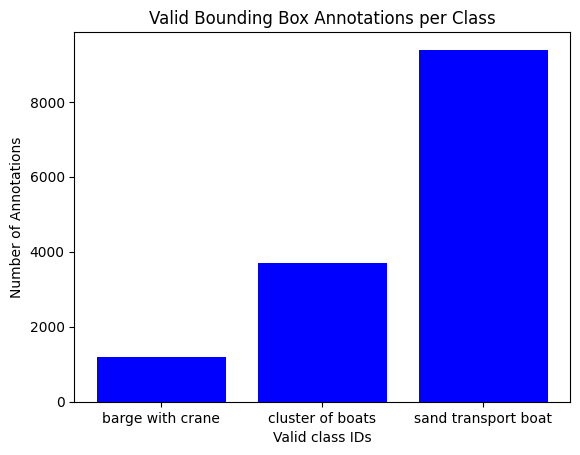

In [36]:
class_ids = list(range(nc))
counts = [all_class_counts[class_id] for class_id in class_ids]
labels = [names[class_id] for class_id in class_ids]

plt.figure()
plt.bar(labels, counts, color = 'blue')
plt.xlabel("Valid class IDs")
plt.ylabel("Number of Annotations")
plt.title("Valid Bounding Box Annotations per Class")
plt.show()


### Dataset analysis wrt images

In [37]:
class_images = {}

for filename in os.listdir(cleaned_data_dir):
    if not filename.endswith(".txt"):
        continue

    with open(os.path.join(cleaned_data_dir, filename)) as file:
        for line in file:
            class_id = int(line.split()[0])

            if class_id not in class_images:
                class_images[class_id] = []

            if filename not in class_images[class_id]:
                class_images[class_id].append(filename)


In [38]:
print("Total images per valid class:")

for class_id in range(nc):
    class_name = names[class_id]
    image_count = len(class_images[class_id])
    print(f"Class {class_id} ({class_name}): {image_count} images")


Total images per valid class:
Class 0 (barge with crane): 631 images
Class 1 (cluster of boats): 1162 images
Class 2 (sand transport boat): 1435 images


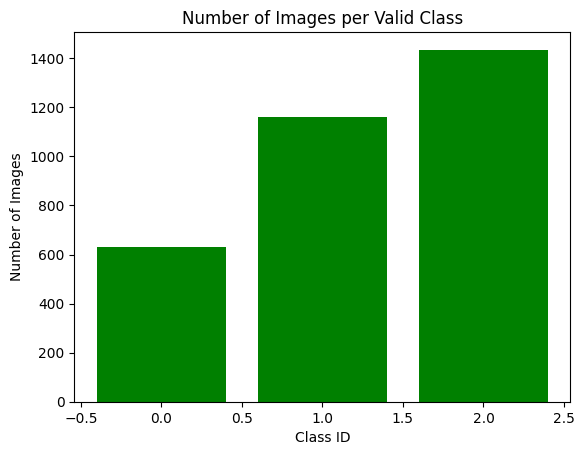

In [39]:
valid_class_ids = []
image_counts = []

for class_id in range(nc):
    valid_class_ids.append(class_id)

    if class_id in class_images:
        image_counts.append(len(class_images[class_id]))
    else:
        image_counts.append(0)

plt.figure()
plt.bar(valid_class_ids, image_counts, color = 'green')
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Number of Images per Valid Class")
plt.show()


### Validation dataset

In [40]:
image_classes = {}

for filename in os.listdir(cleaned_data_dir):
  if not filename.endswith('txt'):
    continue
  with open(os.path.join(cleaned_data_dir, filename)) as file:
    for line in file:
      class_id = int(line.split()[0])
      if filename not in image_classes:
        image_classes[filename] = []

      if class_id not in image_classes[filename]:
        image_classes[filename].append(class_id)

In [41]:
class_image_counts = {}

for classes in image_classes.values():
  for class_id in classes:
    if class_id not in class_image_counts:
      class_image_counts[class_id] = 1
    else:
      class_image_counts[class_id] += 1

In [42]:
val_size = 0.20
target_val_counts = {}
for class_id in range(nc):
  if class_id in class_image_counts:
    target_val_counts[class_id] = int(class_image_counts[class_id] * val_size)
  else:
    target_val_counts[class_id] = 0

In [43]:
target_val_counts

{0: 126, 1: 232, 2: 287}

### Extract validation images from dataset

In [44]:
val_counts = {}

for class_id in target_val_counts:
  val_counts[class_id] = target_val_counts[class_id]

# store validation images in new list
val_images = []
image_names = list(image_classes.keys())
random.shuffle(image_names)

for image_name in image_names:
  classes = image_classes[image_name]
  for class_id in classes:
    if class_id in val_counts:
      if val_counts[class_id] > 0:
        val_images.append(image_name)

        # receeding count of val_counts
        for class_ in classes:
          if class_ in val_counts:
            if val_counts[class_] > 0:
              val_counts[class_] -= 1
        break


In [45]:
train_images = []

for image_name in image_classes:
  if image_name not in val_images:
    train_images.append(image_name)

print(f'Total validation images: ({len(val_images)})')
print(f'Total training images: ({len(train_images)})')

Total validation images: (331)
Total training images: (1388)


In [46]:
new_dataset_path = 'vmd'

train_images_dir = os.path.join(new_dataset_path, 'train_images')
train_labels_dir = os.path.join(new_dataset_path, 'train_labels')

val_images_dir = os.path.join(new_dataset_path, 'val_images')
val_labels_dir = os.path.join(new_dataset_path, 'val_labels')

os.makedirs(train_images_dir, exist_ok = True)
os.makedirs(train_labels_dir, exist_ok = True)
os.makedirs(val_images_dir, exist_ok = True)
os.makedirs(val_labels_dir, exist_ok = True)



In [47]:
for label_name in train_images:

    image_name = label_name.replace(".txt", ".jpg")

    shutil.copy(
        os.path.join("/content/drive/MyDrive/sm_vmd_data/train_images", image_name),
        os.path.join(train_images_dir, image_name)
    )


    shutil.copy(
        os.path.join(cleaned_data_dir, label_name),
        os.path.join(train_labels_dir, label_name)
    )


In [48]:
for label_name in val_images:

    image_name = label_name.replace(".txt", ".jpg")

    shutil.copy(
        os.path.join("/content/drive/MyDrive/sm_vmd_data/train_images", image_name),
        os.path.join(val_images_dir, image_name)
    )

    shutil.copy(
        os.path.join(cleaned_data_dir, label_name),
        os.path.join(val_labels_dir, label_name)
    )


In [49]:
print("Train images:", len(os.listdir(train_images_dir)))
print("Train labels:", len(os.listdir(train_labels_dir)))
print("Val images:", len(os.listdir(val_images_dir)))
print("Val labels:", len(os.listdir(val_labels_dir)))


Train images: 1662
Train labels: 1661
Val images: 829
Val labels: 829


## VGG 16 - Baseline Model

### create VGG-16 dataset for classification

In [50]:
images_dir = "/content/vmd/train_images"
labels_dir = "/content/vmd/train_labels"
vgg_16_path = "/content/vgg_16"

os.makedirs(vgg_16_path, exist_ok=True)

# ---- LOOP THROUGH LABEL FILES ----
for label_file in os.listdir(labels_dir):

    if not label_file.endswith(".txt"):
        continue

    image_file = label_file.replace(".txt", ".jpg")

    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(image_path):
        continue

    img = Image.open(image_path)
    w, h = img.size

    with open(label_path) as f:
        for i, line in enumerate(f):

            parts = line.split()
            class_id = int(parts[0])

            # ✅ FILTER ONLY VALID CLASSES (0,1,2)
            if class_id >= 3:
                continue

            # YOLO values
            xc = float(parts[1])
            yc = float(parts[2])
            bw = float(parts[3])
            bh = float(parts[4])

            # ---- YOLO → PIXEL COORDINATES ----
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)

            # ---- KEEP BOX INSIDE IMAGE ----
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)

            # ---- SKIP INVALID CROPS ----
            if x2 <= x1 or y2 <= y1:
                continue

            crop = img.crop((x1, y1, x2, y2))

            # ---- CREATE CLASS FOLDER ----
            class_folder = os.path.join(vgg_16_path, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            save_name = f"{label_file[:-4]}_{i}.jpg"
            save_path = os.path.join(class_folder, save_name)

            crop.save(save_path)

print("VGG16 crops created successfully.")


VGG16 crops created successfully.


In [51]:
from PIL import Image
import os

# ---- PATHS ----
images_dir = "/content/vmd/train_images"
labels_dir = "/content/vmd/train_labels"
vgg_16_path = "/content/vgg_16"

os.makedirs(vgg_16_path, exist_ok=True)

# ---- LOOP THROUGH LABEL FILES ----
for label_file in os.listdir(labels_dir):

    if not label_file.endswith(".txt"):
        continue

    image_file = label_file.replace(".txt", ".jpg")

    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(image_path):
        continue

    img = Image.open(image_path)
    w, h = img.size

    with open(label_path) as f:
        for i, line in enumerate(f):

            parts = line.split()
            class_id = int(parts[0])

            # ✅ FILTER ONLY VALID CLASSES (0,1,2)
            if class_id >= 3:
                continue

            # YOLO values
            xc = float(parts[1])
            yc = float(parts[2])
            bw = float(parts[3])
            bh = float(parts[4])

            # ---- YOLO → PIXEL COORDINATES ----
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)

            # ---- KEEP BOX INSIDE IMAGE ----
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)

            # ---- SKIP INVALID CROPS ----
            if x2 <= x1 or y2 <= y1:
                continue

            crop = img.crop((x1, y1, x2, y2))

            # ---- CREATE CLASS FOLDER ----
            class_folder = os.path.join(vgg_16_path, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            save_name = f"{label_file[:-4]}_{i}.jpg"
            save_path = os.path.join(class_folder, save_name)

            crop.save(save_path)

print("VGG16 crops created successfully.")


VGG16 crops created successfully.


In [52]:
print(os.listdir(vgg_16_path))

['0', '2', '1']


### Splitting crops into train and validation set

In [53]:
source_dir = "/content/vgg_16"
base_dir = "/content/vgg16_data"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

random.seed(42)

for class_id in os.listdir(source_dir):

    class_source = os.path.join(source_dir, class_id)
    if not os.path.isdir(class_source):
        continue

    class_train = os.path.join(train_dir, class_id)
    class_val   = os.path.join(val_dir, class_id)

    os.makedirs(class_train, exist_ok=True)
    os.makedirs(class_val, exist_ok=True)

    images = os.listdir(class_source)
    random.shuffle(images)

    split_idx = int(len(images) * 0.8)

    train_imgs = images[:split_idx]
    val_imgs   = images[split_idx:]

    for img in train_imgs:
        shutil.copy(os.path.join(class_source, img),
                    os.path.join(class_train, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_source, img),
                    os.path.join(class_val, img))

print("Train/Val split completed.")


Train/Val split completed.


### Data Preprocessing

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)


In [55]:
train_generator = train_datagen.flow_from_directory(
    "/content/vgg16_data/train",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "/content/vgg16_data/val",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)


Found 10921 images belonging to 3 classes.
Found 2731 images belonging to 3 classes.


### Building VGG-16 Model

In [56]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [58]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [60]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [61]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


342/342 ━━━━━━━━━━━━━━━━━━━━ 98s 245ms/step - accuracy: 0.7089 - loss: 0.9062 - val_accuracy: 0.7609 - val_loss: 0.6776
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 72s 211ms/step - accuracy: 0.7889 - loss: 0.5631 - val_accuracy: 0.7272 - val_loss: 0.7210
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 72s 212ms/step - accuracy: 0.8051 - loss: 0.5197 - val_accuracy: 0.7671 - val_loss: 0.5967
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 72s 211ms/step - accuracy: 0.8224 - loss: 0.4651 - val_accuracy: 0.8037 - val_loss: 0.5149
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 72s 211ms/step - accuracy: 0.8367 - loss: 0.4334 - val_accuracy: 0.8037 - val_loss: 0.5244
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 73s 213ms/step - accuracy: 0.8366 - loss: 0.4302 - val_accuracy: 0.8041 - val_loss: 0.4934
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 73s 213ms/step - accuracy: 0.8378 - loss: 0.4272 - val_accuracy: 0.8085 - val_loss: 0.5354
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 73s 212ms/step - accuracy: 0.8456 - loss: 0.4056 - val

### Check accuracy and loss for baseline model

In [65]:
val_loss, val_acc = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.8216 - loss: 0.5093
Validation Loss: 0.49630576372146606
Validation Accuracy: 0.8202123641967773


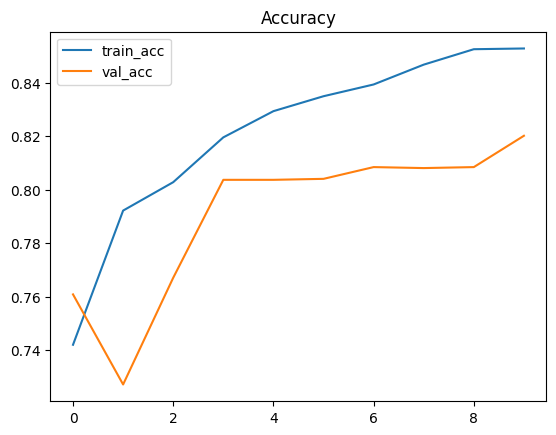

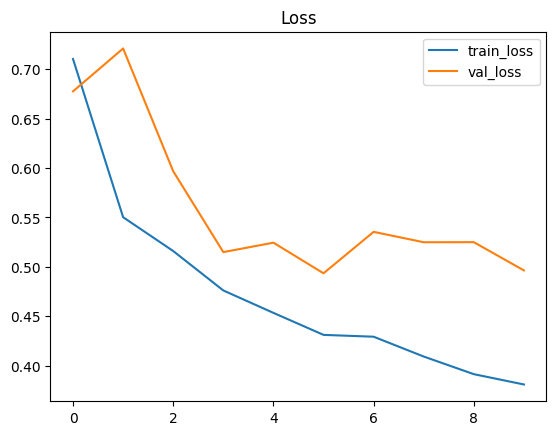

In [66]:
# Accuracy plot
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


### VGG-16 Model tuning

In [67]:
# Adding 4 more layers
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False


In [68]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [69]:
history_ft1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 87s 239ms/step - accuracy: 0.8712 - loss: 0.3418 - val_accuracy: 0.8184 - val_loss: 0.4908
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 80s 234ms/step - accuracy: 0.8938 - loss: 0.2819 - val_accuracy: 0.8217 - val_loss: 0.4840
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 80s 235ms/step - accuracy: 0.8971 - loss: 0.2758 - val_accuracy: 0.8239 - val_loss: 0.4806
Epoch 4/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.9139 - loss: 0.2429 - val_accuracy: 0.8180 - val_loss: 0.5021
Epoch 5/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 81s 237ms/step - accuracy: 0.9185 - loss: 0.2241 - val_accuracy: 0.8224 - val_loss: 0.4882


In [73]:
val_loss, val_acc = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.8260 - loss: 0.5044
Validation Loss: 0.48436346650123596
Validation Accuracy: 0.8388868570327759


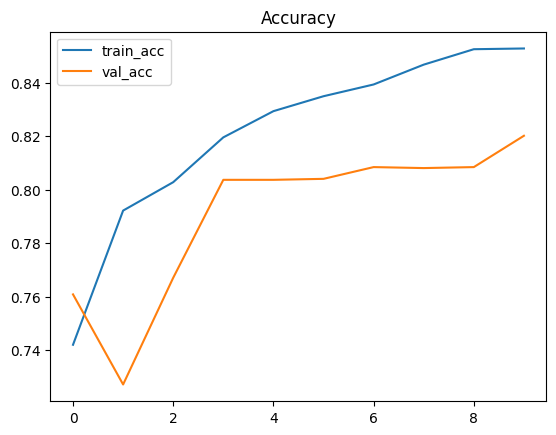

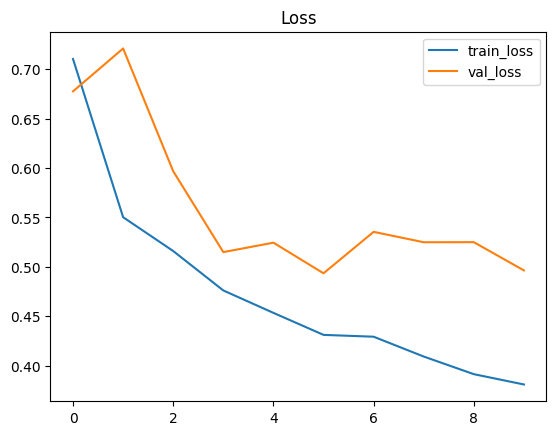

In [74]:
# Accuracy plot
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [70]:
# Adding another 4 layers
for layer in base_model.layers[:-8]:
    layer.trainable = False



In [71]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [72]:
history_ft1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.9291 - loss: 0.1975 - val_accuracy: 0.8338 - val_loss: 0.4781
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.9346 - loss: 0.1917 - val_accuracy: 0.8374 - val_loss: 0.4652
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.9438 - loss: 0.1731 - val_accuracy: 0.8371 - val_loss: 0.4727
Epoch 4/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.9453 - loss: 0.1638 - val_accuracy: 0.8382 - val_loss: 0.4794
Epoch 5/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 81s 237ms/step - accuracy: 0.9481 - loss: 0.1609 - val_accuracy: 0.8389 - val_loss: 0.4844


In [76]:
val_loss, val_acc = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.8378 - loss: 0.4833
Validation Loss: 0.48436325788497925
Validation Accuracy: 0.8388868570327759


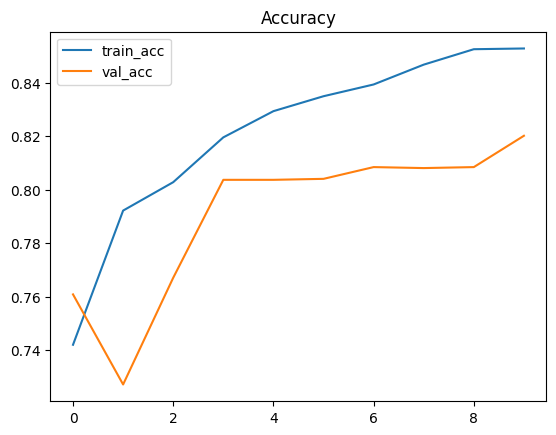

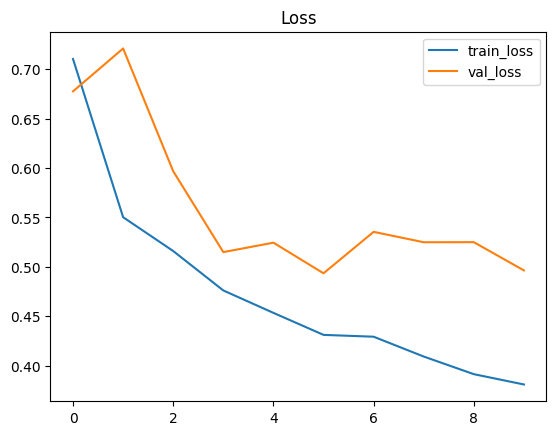

In [75]:
# Accuracy plot
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()
